In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


C:\Users\CY\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


Text(0, 0.5, 'Precipitation')

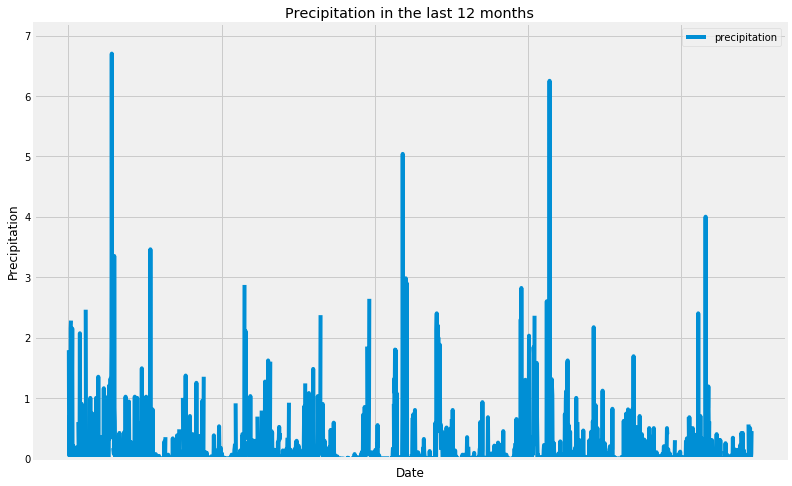

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
    
    #explore the tables 
##engine.execute('SELECT * FROM Station').fetchall()
##engine.execute('SELECT * FROM Measurement').fetchall()

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])
    
    ## the last day in the table: 8/23/2017
EndDate = dt.date(2017, 8, 23)
#print(EndDate)
    
# Calculate the date 1 year ago from the last data point in the database
    ## use timedelta to calculate the date 1 year ago from the last date in the table
from datetime import timedelta
OneYear = timedelta(days=365)
StartDate = EndDate - OneYear
#print(StartDate)

# Perform a query to retrieve the data and precipitation scores
P_Results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date>=StartDate).filter(Measurement.date<=EndDate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Prcp_df = pd.DataFrame(P_Results,columns=['date', 'precipitation'])
Prcp_df.set_index(Prcp_df["date"], inplace=True)

# Sort the dataframe by date
Prcp_df = Prcp_df.sort_values("date")
#Prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12,8))
Prcp_df.plot(ax=ax)
ax.set_ylim(0,max(Prcp_df['precipitation']+0.5))
ax.set_title("Precipitation in the last 12 months")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Prcp_df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
NumofStations = session.query(Station).count()
print(f"There are {NumofStations} stations available in this dataset.")

There are 9 stations available in this dataset.


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
ActiveRank = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

Active_df = pd.DataFrame(ActiveRank,columns=['Station #', 'Num of Records'])
MostActiveStation = Active_df['Station #'][0]
#print(f"The most active station is Station {MostActiveStation}, which has 2772 records.")

    #List of all stations with their number of observation records:
Active_df



,Station #,Num of Records
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
Lowest_Temperature = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
Highest_Temperature = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
Avg_Temperature = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

print(f"@ The most active station #USC00519281,\
the lowest temperature recorded was {Lowest_Temperature} degree;\
the highest temperature recorded was {Highest_Temperature} degree;\
and average temperature was {Avg_Temperature} degree.")
              

@ The most active station #USC00519281,the lowest temperature recorded was [(54.0,)] degree;the highest temperature recorded was [(85.0,)] degree;and average temperature was [(71.66378066378067,)] degree.


Text(0, 0.5, 'Frequency')

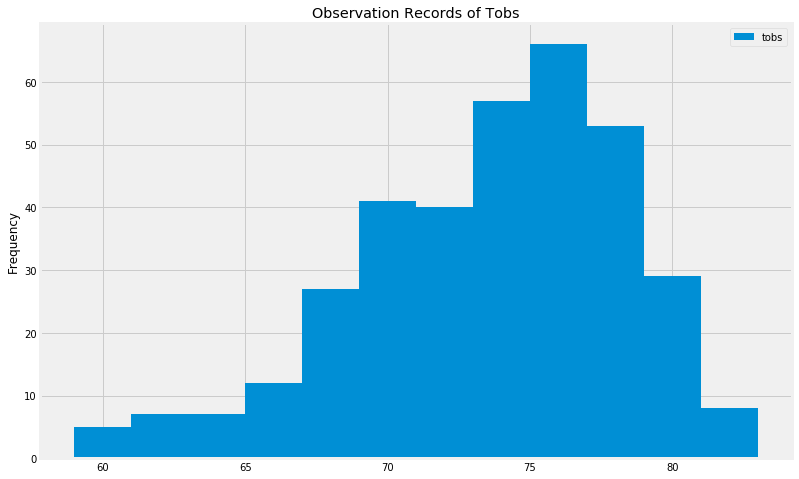

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
    
    # The station with the highest number of temperature observation has been defined
    # Dates range and variables have been defined before as well 
S_Results = session.query(Measurement.tobs).\
            filter(Measurement.station == MostActiveStation).\
            filter(Measurement.date>=StartDate).filter(Measurement.date<=EndDate).all()

Temp_df = pd.DataFrame(S_Results)
Temp_df.head()

    # Plot the data from Temp_df
ax = Temp_df.plot(kind="hist",bins=12,figsize=(12,8))
ax.set_title("Observation Records of Tobs")
ax.set_ylabel("Frequency")


In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# print(calc_temps('2016-12-24', '2017-01-02'))
vacation_temp = calc_temps('2016-12-24', '2017-01-02')[0]
tmin = vacation_temp[0]
tavg = vacation_temp[1]
tmax = vacation_temp[2]
print(tmin, tavg, tmax)

62.0 71.41666666666667 78.0


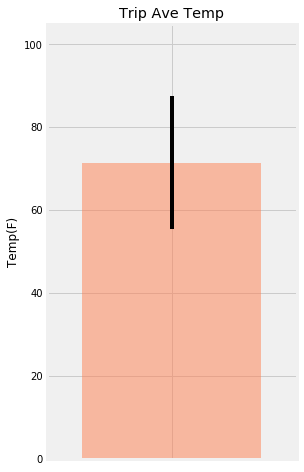

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2))
yerr = tmax - tmin
x = 1
width =0.4
ax.margins(0.2, 0.2)

plt.bar(x,tavg,width,linewidth=8, alpha=0.5, tick_label="", color="coral",yerr=yerr)
plt.title("Trip Ave Temp")
plt.ylabel("Temp(F)")
plt.show()

In [66]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Station_Data = session.query(Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date>=StartDate).filter(Measurement.date<=EndDate).\
            group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print(Station_Data)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 147.81000000000006), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 70.03000000000003), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 48.510000000000026), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 38.01), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 33.239999999999995), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 16.089999999999986), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
